In [1]:
import PIL
from PIL import Image
import torch
from torch.autograd import Variable
from torchvision import transforms
import DIW_transforms
import numpy as np 
from models.hourglass import Model

In [2]:
sz = (320, 240)
model = Model()
model.load_state_dict(torch.load('weights.ckpt', map_location='cpu'))

In [3]:
def batchify(raw_im_array, sz):
    tfms = DIW_transforms.get_tfms(sz)
    batch = []
    
    for im in raw_im_array:
        batch.append(tfms(im))
    
    tensor_batch = torch.stack(batch)
    return Variable(tensor_batch)

def get_pred_depth_maps(preds):
    op_size = preds.size()
    h, w = op_size[2], op_size[3]
    n_pixels = h*w
    depths_batch = preds.data

    depths_batch = depths_batch.view(-1, n_pixels)

    image_wise_min = depths_batch.min(dim=1)[0] 
    image_wise_min = image_wise_min.unsqueeze(dim=1) 
    
    depths_batch = depths_batch - image_wise_min
    
    image_wise_max = depths_batch.max(dim=1)[0]
    image_wise_max = image_wise_max.unsqueeze(dim=1)
    depths_batch = depths_batch / image_wise_max

    depths_batch = depths_batch.view(-1, 1, h, w)
    depths_batch = (depths_batch*255).type(torch.IntTensor)
    depths_batch = depths_batch.squeeze(dim=1).numpy()
    return depths_batch

In [4]:
#image batch would be a numpy array NxHxWx3
im_batch = np.array([np.asarray(Image.open('IMG_4121.jpg').rotate(180)), np.asarray(Image.open('IMG_4122.jpg').rotate(180))])

def predict(model, im_batch):
    with torch.no_grad():
        model.eval()
        batch = batchify(im_batch, sz)
        preds = model(batch)
        return get_pred_depth_maps(preds)

In [5]:
depths_batch = predict(model, im_batch)

/Users/Margaux/anaconda/envs/p36workshop/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:177: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingNearest2d is deprecated. Use nn.functional.interpolate instead.")
/Users/Margaux/anaconda/envs/p36workshop/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


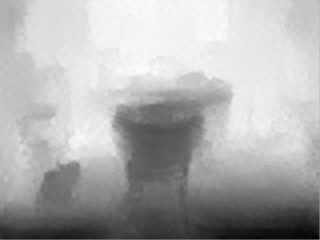

In [6]:
Image.fromarray(depths_batch[0].astype('uint8'))